# Import Relevant Libraries

In [1]:
import pickle
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import ml_pipeline.cleanse as cl
import ml_pipeline.feature_engineering as fe
import ml_pipeline.encode as enc

# Data Preprocessing

### Import and initial prep

In [2]:
# Import data set
path = "./data/supply_chain.csv"
data = pd.read_csv(path)
data.head()

,material,mgmt_escalated,ordered_inside_lead_time,phone_calls_placed,received_on_time,req_date_month,req_date_qtr,supplier_warning,units_ordered,price,total_order,lead_time,supplier
0,ACZ636,Y,N,13.0,Y,11.0,4.0,No communication,181.0,18.18,3290.58,2.0,SS3
1,AXX172,N,NaN,4.0,N,2.0,1.0,No communication,38.0,12.98,493.24,2.0,CX4
2,AYY404,Y,Y,12.0,N,2.0,1.0,Told it would be late,73.0,316.07,23073.11,17.0,MT4
3,AXX172,N,N,12.0,Y,6.0,2.0,Told it would be on time,137.0,12.98,1778.26,2.0,CX4
4,AXX172,Y,N,8.0,Y,6.0,2.0,No communication,183.0,12.98,NaN,2.0,CX4


### Non-pipeline transformations (anything that touches the target variable)

In [3]:
# Split target from data
target = 'received_on_time'

# Drop records w/o target (can't train if no target)
data.dropna(subset = [target], inplace=True)

# Drop duplicates
data.drop_duplicates(inplace=True)

# Any transformation of target for regression (like Ln) will need to occur before the pipeline...
#
#
#

### Train Test Split

In [ ]:
# Separate target from the rest of the data
cols = list(data.columns)
cols.remove(target)

# Define dependent and independent variables
y = data[target]
X = data[cols]

# Immediately train test split
x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

# Export training set for EDA in CDS (DON'T LOOK AT YOUR TEST SET EVER!!!)
training = pd.concat([x_tr, y_tr], axis=1, ignore_index=False)

# Where to save the training set for EDA in CDS
output_path = "./data/ml_project_eda.csv"

training.to_csv(output_path, index=False)

### EDA and Build Pipeline (Open your _eda file in your favorite tool and start exploring)

In [5]:
# Instantiate the pipeline steps list
    # This is going to be the "recipe" for the pipeline. Every step is a tuple that looks like: ("name", step_object)
    # step_object is going to have all the arguments we want to use already included. Ex: CastToCategory(variable = "req_date_qtr")
steps = [] 

# Instantiate pipeline (IngestAndPrepare always first)
steps.append(("Ingest and Prepare", cl.IngestAndPrepare()))

### Cleansing

In [6]:
# Generate list of numeric vs categorical variables
print(x_tr.columns)

Index(['material', 'mgmt_escalated', 'ordered_inside_lead_time',
       'phone_calls_placed', 'req_date_month', 'req_date_qtr',
       'supplier_warning', 'units_ordered', 'price', 'total_order',
       'lead_time', 'supplier'],
      dtype='object')


In [7]:
nums = ['phone_calls_placed', 'units_ordered', 'price', 'total_order', 'lead_time']

cats = ['material', 'mgmt_escalated', 'ordered_inside_lead_time', 'supplier', 'supplier_warning',
        'req_date_qtr','req_date_month']

In [ ]:
# Cast numeric to category where appropriate
steps.append(("Cast req_date_qrt to cat", cl.CastToCategory('req_date_qtr')))
steps.append(("Cast req_date_month to cat",cl.CastToCategory('req_date_month')))

In [9]:
# Missing values (just to be safe for new data, correct missing values on all variables) and casing
# In CDS, go to the "summary" tab after importing data to see which variables have missing values
    # Numeric variables
for n in nums:
    steps.append((f"Cast {n} missing vals to median", cl.ImputeMissingNumbers(n, 'median')))
    # Categorical variables
for c in cats:
    steps.append((f"Cast {c} classses to lower case",cl.CommonCaseClasses(c, 'lower')))
    steps.append((f"Cast {c} missing vals to mode",cl.ImputeMissingClasses(c, 'mode')))

In [10]:
# Rare Classes 
# In CDS, go to "Single Variable" and look at each categorical variable to see if anything is rare
steps.append(("Correct material rare classes @ 5%", cl.HandleRareClasses('material', threshold = .05))) # 5% looked reasonable to elim the last 3 tiny materials

# Req Qtr and Req Mo... will need to remove the bad values!

In [11]:
# Outliers
# In CDS, go to "Single Variable" and look at each numeric variable to see if any outliers exist
# Also, look at the histogram to get a feel for what feature engineering transformations you may want to do
    # phone_calls_placed
steps.append(("Handling outliers for phone_calls_placed", cl.ManualOutliers('phone_calls_placed', 20, 'right'))) # based on histogram, we can kill that right tail
    
    # units_ordered (can't order negative values)
steps.append(("Handling outliers for units_ordered", cl.ManualOutliers('units_ordered', 0, 'left')))

    # units_ordered (big fat finger outlier in this one on the right tail)
steps.append(("Handling outliers for price", cl.ManualOutliers('price', 2000, 'right')))

    # total_order (extreme distribution here... will treat w/ Ln instead of trying to fix outliers)

    # lead_time (looks fine)

### Feature Engineering

In [12]:
# Compress Classes
    # Correct req month 13 error (must be cast as strings - we are treating this ordinally, not numerically)
map_dict = {'13':'12'}
steps.append(("Compressing req_date_month classes", fe.CompressClasses('req_date_month', map_dict)))
    # would correct req qtr 6 error, but just going to drop the variable
    
# class compression for categorical target is hard (can't just bucket by means unless there is a numeric correlate)
    # going to use lead time as the highest numeric correlate to target, and lead time vs material are strongly related
map_dict = {'abz581':'low_lead',
            'aaz212':'low_lead',
            'acz636':'low_lead',
            'axx172':'low_lead',
            'axx171':'low_lead'}
steps.append(("Compressing material classes", fe.CompressClasses('material', map_dict)))

Matplotlib is building the font cache; this may take a moment.


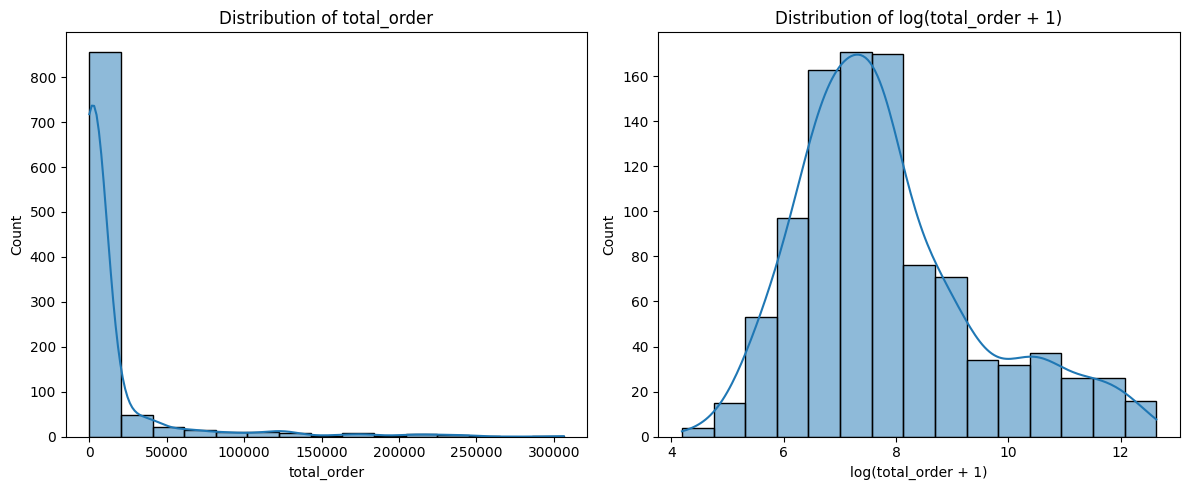

In [13]:
# Visualizing LN transformation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

var = 'total_order' # 'phone_calls_placed'

# Plot histogram for phone_calls_placed
sns.histplot(data[var].dropna(), bins=15, kde=True, ax=axes[0])
axes[0].set_title(f'Distribution of {var}')
axes[0].set_xlabel(var)

# Plot histogram for log(phone_calls_placed+1)
sns.histplot(np.log(data[var].dropna() + 1), bins=15, kde=True, ax=axes[1])
axes[1].set_title(f'Distribution of log({var} + 1)')
axes[1].set_xlabel(f'log({var} + 1)')

plt.tight_layout()
plt.show()


In [14]:
# Numeric transformations (Ln, Power, Interact, Scalar)
    # LN phone_calls_placed
steps.append(("Ln phone_calls_placed", fe.Ln('phone_calls_placed', drop_orig = True)))

    # LN total_order
steps.append(("Ln total_order", fe.Ln('total_order', drop_orig = True)))

In [ ]:
# Drop variables
# In CDS, these look pretty useless; not going to waste compute power on columns this bad
steps.append(("Dropping req_date_qtr", fe.DropVar('req_date_qtr')))
cats.remove('req_date_qtr') # pull from list of categorical variables (will need to do this for OneHotEncode)

### Encode

In [ ]:
steps.append(("OneHotEncoding", enc.OneHotEncode(cats)))

### Make Pipeline

In [ ]:
pipe = Pipeline(steps)

In [ ]:
# fit and transform the training set
    # fit will store all our parameters for our various functions/calculate others based on the data
    # transform will actually execute the transformations
    # fit_transform will do both at the same time (us being lazy)
x_tr = pipe.fit_transform(x_tr)
assert len(x_tr) == len(y_tr), "Training set length mismatch!!!"
x_tr.head()

In [ ]:
# transform the test set (we've already fit all of our parameters... want to use those methods to transform test data)
x_te = pipe.transform(x_te)

In [ ]:
# Pickle and save the pipeline
with open("./pickles/data_pipeline.pickle", 'wb') as handle:
    pickle.dump(pipe, handle)